In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "gpu"                 # comment out if CPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from jax import config
config.update("jax_enable_x64", True)
import jax
print(jax.default_backend(), jax.devices()) 
from pfcheeshmc import *

gpu [CudaDevice(id=0)]


# Extreme Value Example
Based on the Port Pirie example in Coles (2001).
See also: https://www.pymc.io/projects/examples/en/latest/case_studies/GEV.html

Require `pymc-extras`: https://www.pymc.io/projects/extras/en/latest/

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pymc_extras as pmx

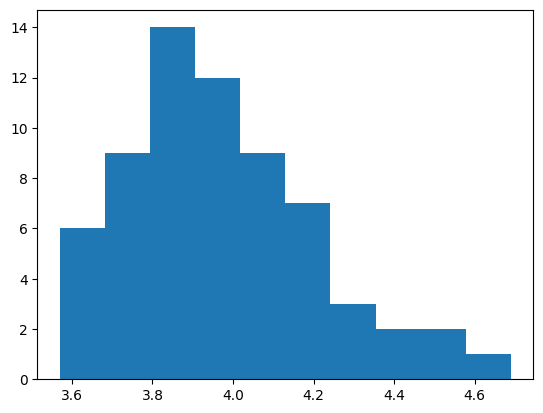

In [3]:
# fmt: off
data = np.array([4.03, 3.83, 3.65, 3.88, 4.01, 4.08, 4.18, 3.80, 
                 4.36, 3.96, 3.98, 4.69, 3.85, 3.96, 3.85, 3.93, 
                 3.75, 3.63, 3.57, 4.25, 3.97, 4.05, 4.24, 4.22, 
                 3.73, 4.37, 4.06, 3.71, 3.96, 4.06, 4.55, 3.79, 
                 3.89, 4.11, 3.85, 3.86, 3.86, 4.21, 4.01, 4.11, 
                 4.24, 3.96, 4.21, 3.74, 3.85, 3.88, 3.66, 4.11, 
                 3.71, 4.18, 3.90, 3.78, 3.91, 3.72, 4.00, 3.66, 
                 3.62, 4.33, 4.55, 3.75, 4.08, 3.90, 3.88, 3.94, 
                 4.33])
# fmt: on
plt.hist(data)
plt.show()

In [4]:
p = 1/10 #Return period
mean_data = np.mean(data)
std_data = np.std(data)

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=3.8, sigma=0.2)
    σ = pm.HalfNormal("σ", sigma=0.3)
    ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.6, upper=0.6)

    # Estimation, non-centering
    gev = pmx.GenExtreme(
        "gev", 
        mu=μ, 
        sigma=σ,
        xi=ξ, 
        observed=data
    )
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

/home/default/miniforge3/envs/blackjax/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sampling: [gev, μ, ξ, σ]


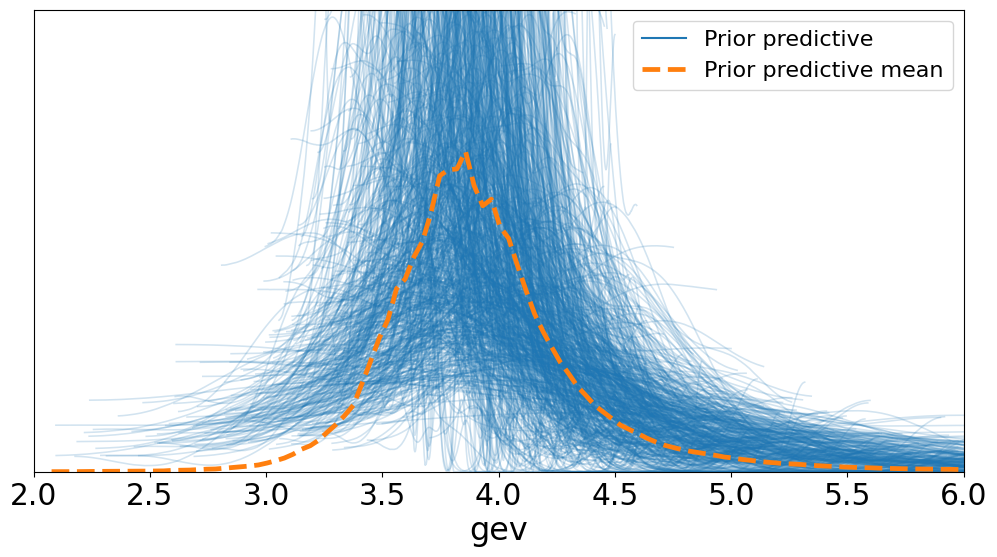

In [5]:
idata = pm.sample_prior_predictive(samples=1000, model=model)
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

In [6]:
# Sampling
with model:
    posterior_trace = sample_pf_chees_hmc(
        chains=32,
        draws=2000,
        pathfinder_kwargs={"draws":10_000},
        chees_kwargs={"draws": 10_000}
    )
idata.extend(posterior_trace)

Initializing ChEES-HMC using pathfinder+adapt_diag...


ε Tuning:   0%|          | 0/32 [00:00<?, ?it/s]

ChEES Adaptation:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling Dynamic HMC:   0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3.872,0.028,3.820,3.924,0.000,0.0,45184.0,34863.0,1.0
σ,0.204,0.021,0.166,0.244,0.000,0.0,45119.0,29987.0,1.0
ξ,-0.028,0.088,-0.193,0.138,0.001,0.0,17701.0,18372.0,1.0
z_p,4.319,0.062,4.209,4.435,0.000,0.0,39583.0,30118.0,1.0


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'ξ'}>, <Axes: title={'center': 'ξ'}>],
       [<Axes: title={'center': 'z_p'}>, <Axes: title={'center': 'z_p'}>]],
      dtype=object)

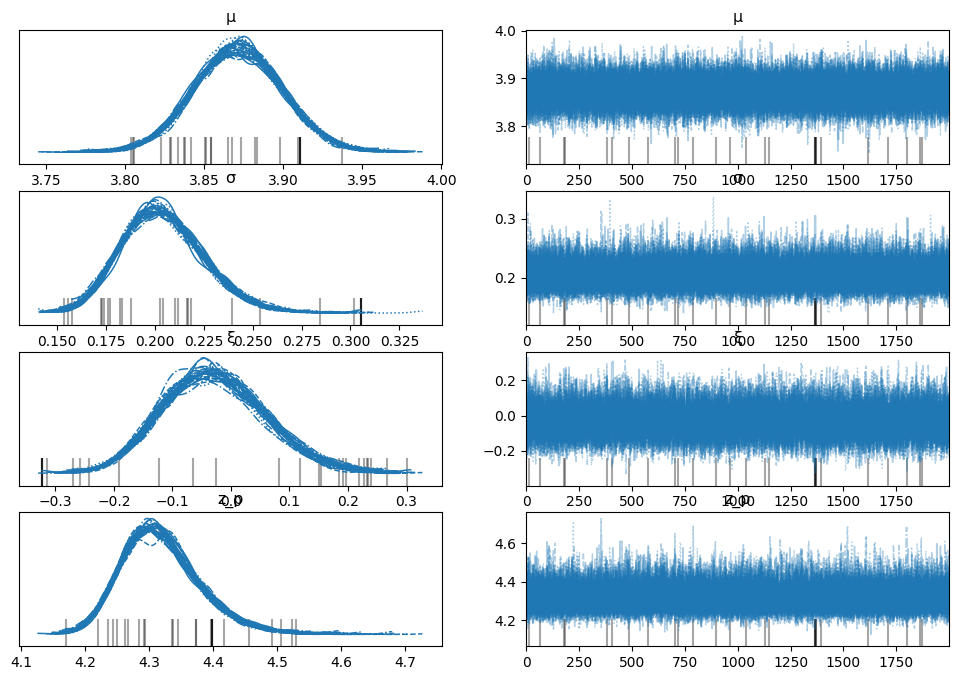

In [8]:
az.plot_trace(idata)

In [9]:
post_idata = pm.sample_posterior_predictive(posterior_trace, model=model)
idata.extend(post_idata)

Sampling: [gev]


Output()

array([[<Axes: >, <Axes: >, <Axes: xlabel='σ'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='μ'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='z_p'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='ξ'>]], dtype=object)

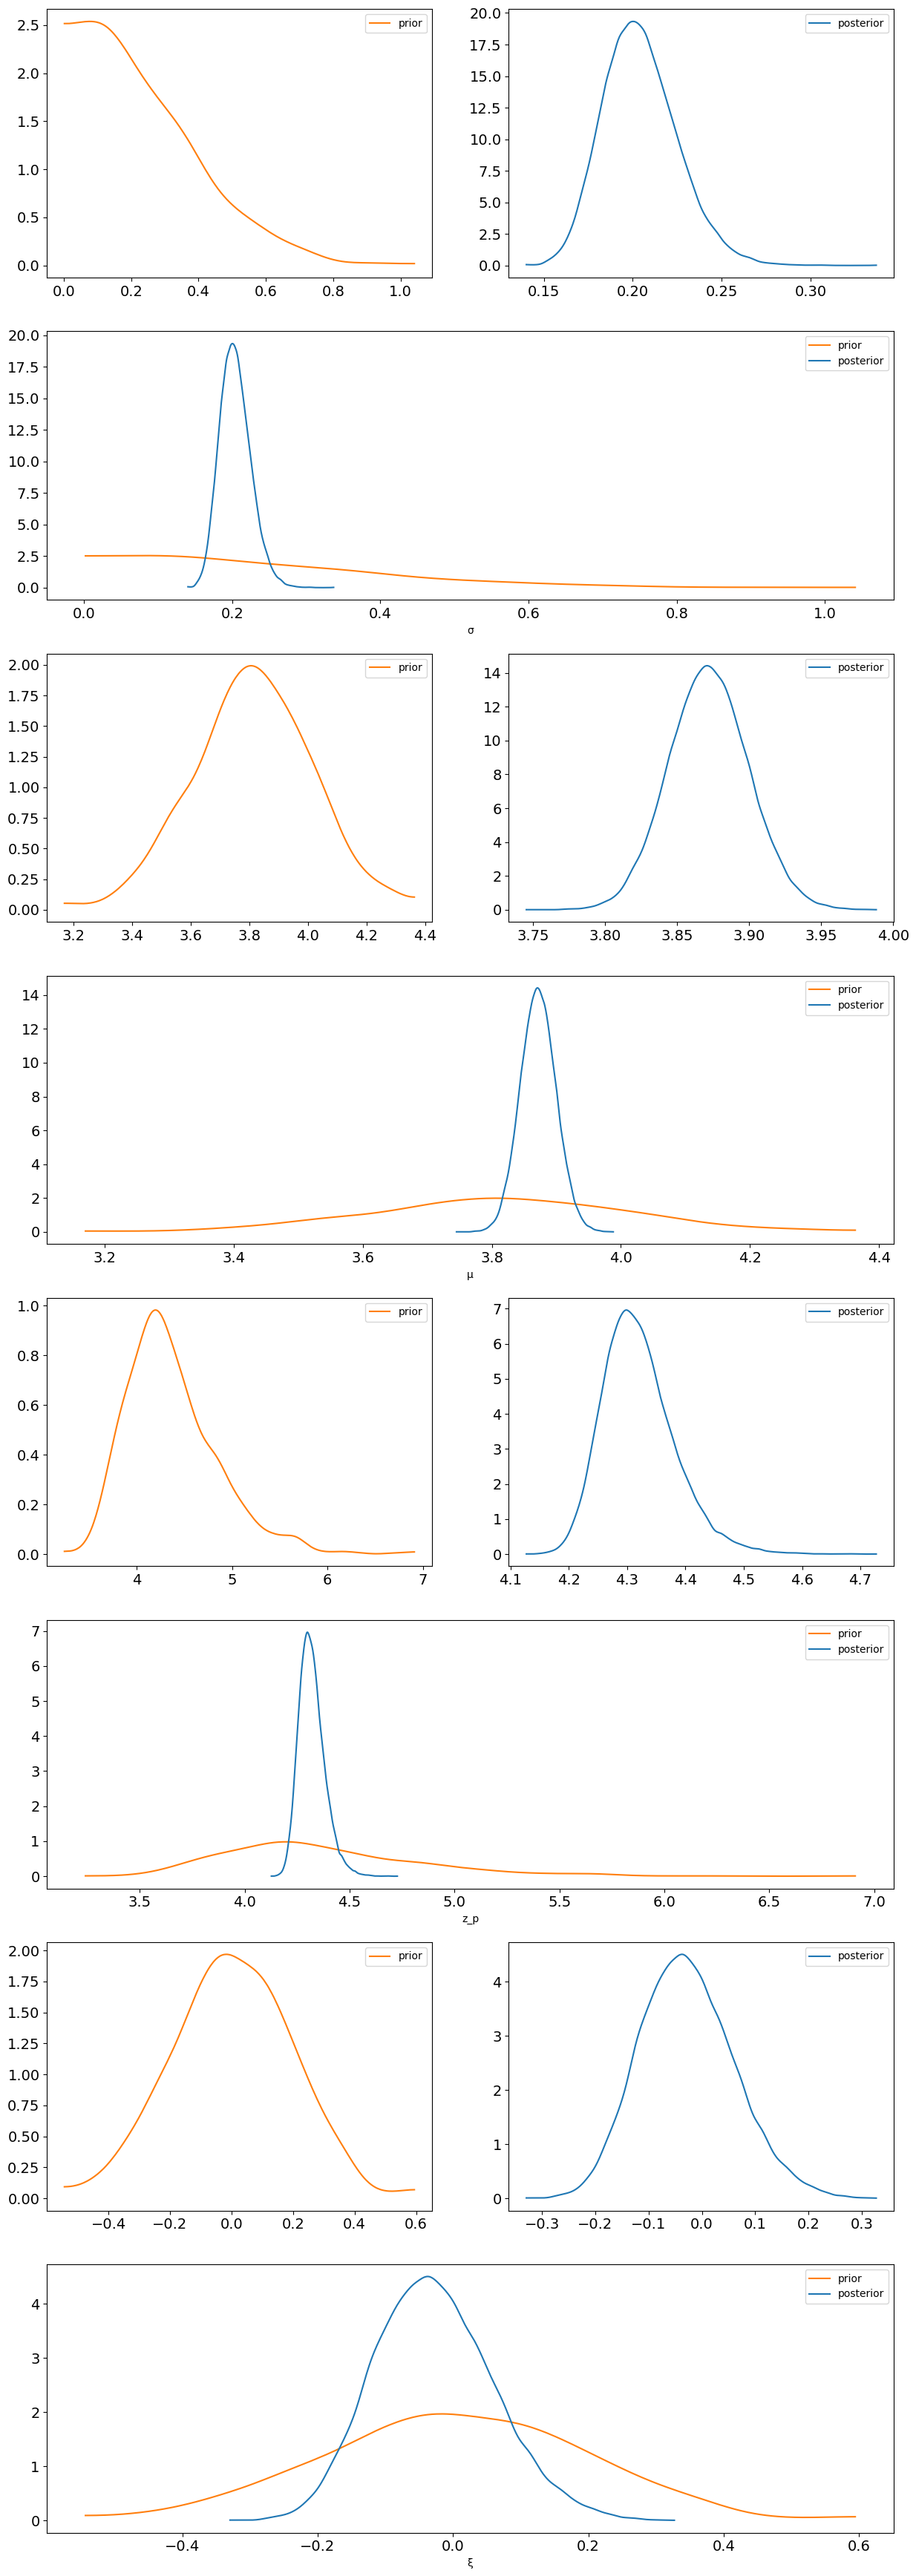

In [10]:
az.plot_dist_comparison(idata)

# NUTS
Compare with PyMC implementation of NUTS

In [11]:
with model:
    nuts_idata = pm.sample(draws=2000, chains=4, tune=2000, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
/home/default/miniforge3/envs/blackjax/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/home/default/miniforge3/envs/blackjax/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3.871,0.028,3.821,3.924,0.000,0.000,4176.0,4536.0,1.0
σ,0.204,0.021,0.168,0.245,0.000,0.000,3726.0,4353.0,1.0
ξ,-0.026,0.089,-0.186,0.143,0.001,0.001,3644.0,4103.0,1.0
z_p,4.319,0.062,4.209,4.439,0.001,0.001,4644.0,4255.0,1.0


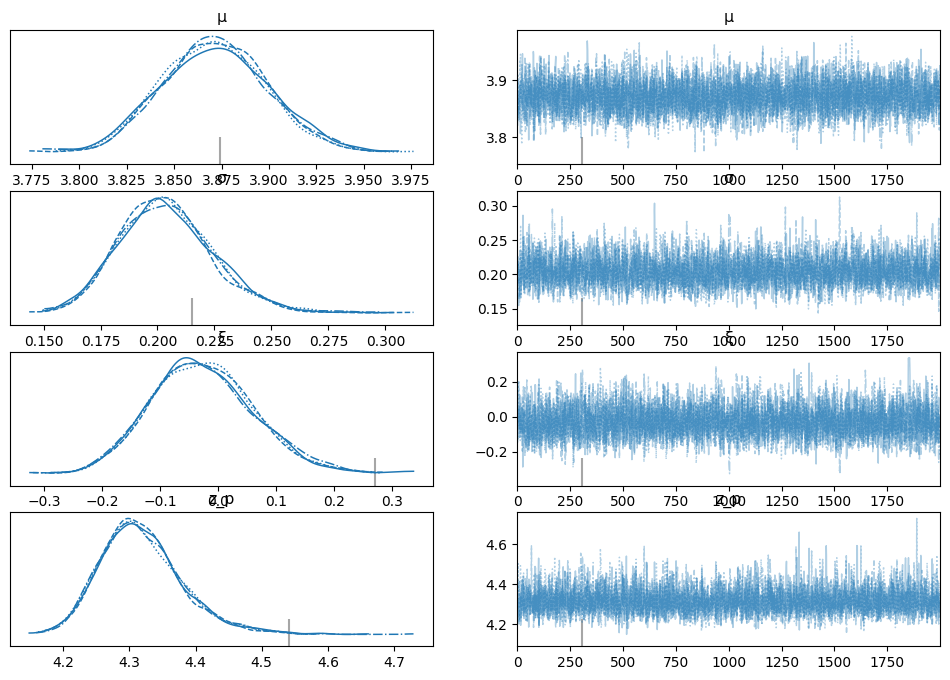

In [12]:
az.plot_trace(nuts_idata)
az.summary(nuts_idata)